# Hospital allocation policy in King County, WA

In [1]:
import pandas as pd
import random
import simpy
import warnings
warnings.filterwarnings('ignore')
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [2]:
# Rank, admission type, and number of replicate may vary
class Globvars:
    def __init__(self, _rank, _admis_type, _num_replicate):
        # based on patient_admit.csv
        self.run_length = 250
        self.admis_type = _admis_type
        self.num_replicate = _num_replicate


        # from estimated probabilistic LOS
        self.cohort_num = 5
        self.cohort_prob = [0.704, 0.834, 0.852, 0.982, 1.0] # cumulative sum
        self.cohort_trajectory = [['NC'], ['NC, ICU', 'NC'], ['NC','ICU'], ['ICU', 'NC'], ['ICU']]
        self.cohort_traj_LOS = [[5],[4,9,4],[6,9],[9,4],[11]] # LOS corresponding to trajectory place

        # ranking system
        self.rank = _rank

In [3]:
class Population:
    def __init__(self, globvars):
        self.globvars = globvars
        self.patients = dict() # Patient populations
        self.daily_new_patients = [] # patient unallocated (newly admitted)
        self.rejected_patients = [0 for x in range(self.globvars.run_length)] # patient rejected today
        self.cohort_type =[0]*self.globvars.cohort_num

In [4]:
class Hospital:
    """
    initialize capacity for covid patients. 
    open2covid_daily = 0 or 1
    NC_daily_occ[bed_num][day] = 0 or 1. 
    NC_daily_pat[bed_num][day] = patient number
    """
    def __init__ (self, globvars, env, hospital_id, rank, ICU_avail, NC_avail):
        self.env = env
        self.globvars = globvars
        self.hospital_id = hospital_id
        self.rank = rank
        self.NC_avail = NC_avail
        self.ICU_avail = ICU_avail
                
        self.open2covid_daily = [0 for x in range(self.globvars.run_length)]
        self.NC_daily_occ = [[0 for x in range(self.globvars.run_length)] for y in range(self.NC_avail)]
        self.ICU_daily_occ = [[0 for x in range(self.globvars.run_length)] for y in range(self.ICU_avail)]
        
        self.NC_daily_pat = [[0 for x in range(self.globvars.run_length)] for y in range(self.NC_avail)] 
        self.ICU_daily_pat = [[0 for x in range(self.globvars.run_length)] for y in range(self.ICU_avail)] 

In [5]:
class Patient:
    def __init__ (self, globvars, env, pop, time_in, patient_id, cohort_type, troj):        
        self.env = env
        self.globvars = globvars
        self.pop = pop        
        self.time_in = time_in
        self.patient_id = patient_id
        self.cohort_type = cohort_type
        self.allocated = False
        self.hospital_id = -1
        self.bed_NC = -1
        self.bed_ICU = -1
        self.time_out = -1
        self.troj = troj
        self.set_trajectory()
#       
    def set_trajectory(self):
        """
        make a trajectory into 0 or 1 in total run length. 
        For example, if stay at ICU for 5 days from day 3, traj_ICU = [0,0,0,1,1,1,1,1,0,0,...0], 
        Give fixed LOS for now. will improve later
        """
        start_date = self.time_in
        cohort_type = self.cohort_type
        total_run_length = self.globvars.run_length
        my_troj = self.troj
        my_total_length = sum(my_troj)

        # initialize trajectory with zeros
        traj_NC, traj_ICU=[0]*total_run_length, [0]*total_run_length

        # fill 1 with cohort type (NC, NC-ICU-NC, NC-ICU ...)
        for i in range(start_date, start_date+my_total_length):        
            if cohort_type == 0:
                traj_NC[i]=1
                
            elif cohort_type == 1:
                if (i<start_date+my_troj[0]):traj_NC[i] = 1
                elif (i<start_date+my_troj[0]+my_troj[1]): traj_ICU[i] = 1
                else: traj_NC[i] = 1
                    
            elif cohort_type == 2:
                if (i<start_date+my_troj[0]): traj_NC[i] = 1
                else: traj_ICU[i] = 1
            
            elif cohort_type == 3:
                if (i<start_date+my_troj[0]): traj_ICU[i] = 1
                else: traj_NC[i] = 1

            elif cohort_type == 4:
                traj_ICU[i]=1

        self.traj_NC = traj_NC
        self.traj_ICU = traj_ICU
        self.time_out = self.time_in+my_total_length


In [6]:
class Hospitals:
    def __init__(self):
        self.hospitals_by_rank = []# Hospital list
        self.open_hospitals_by_rank = [] # Hospital open to covid patients, sorted by rank, changes everyday
        self.count =0
        self.candid_count=0
        self.not_open_NC = 0
        self.not_open_ICU = 0
        
    
    def assign_hospital(self, patient, day):
        open_hosp_list = self.open_hospitals_by_rank
        # search available bed from open_hospitals_by_rank
        i=0
        while(patient.allocated == False and i<len(open_hosp_list)):
            avail_NC, avail_ICU = self.check_available_in_hosp(open_hosp_list[i], patient) # get available bed number
            if (avail_NC != "N/A") and (avail_ICU!= "N/A"): # if both NC and ICU bed are found, assign
                self.assign_bed(open_hosp_list[i],patient,avail_NC, avail_ICU)
            else:
                i+=1
                if(i==len(open_hosp_list)): # if current hospital is the last hospital in the opened list, open new one
                    new_hosp_avail = self.open_new_hosp(day, patient)


    def assign_bed(self,hospital, patient, avail_NC, avail_ICU):
        patient.allocated = True
        patient.hospital_id = hospital.hospital_id
        patient.bed_NC = avail_NC
        patient.bed_ICU = avail_ICU

        # Set occupancy and patient id for assigned bed
        if(hospital.NC_avail >0):
            NC_add_occ = patient.traj_NC
            NC_add_patient = [i * patient.patient_id for i in NC_add_occ]
            hospital.NC_daily_occ[avail_NC] = [x + y for x, y in zip(hospital.NC_daily_occ[avail_NC], NC_add_occ)]
            hospital.NC_daily_pat[avail_NC] = [x + y for x, y in zip(hospital.NC_daily_pat[avail_NC], NC_add_patient)]
        if(hospital.ICU_avail >0):
            ICU_add_occ = patient.traj_ICU
            ICU_add_patient = [i * patient.patient_id for i in ICU_add_occ]
            hospital.ICU_daily_occ[avail_ICU] = [x + y for x, y in zip(hospital.ICU_daily_occ[avail_ICU], ICU_add_occ)]
            hospital.ICU_daily_pat[avail_ICU] = [x + y for x, y in zip(hospital.ICU_daily_pat[avail_ICU], ICU_add_patient)]
        
    # First hospital always opens
    def open_first_hosp(self, day):
        current_open_num = len(self.open_hospitals_by_rank) # current number of hospitals open
        new_hospital = self.hospitals_by_rank[current_open_num]
        self.open_hospitals_by_rank.append(new_hospital)
        new_hospital.open2covid_daily[day] = 1
        self.count+=1
        return
    
    # 2nd~ hospital opens only if they have enough capacity for incoming patients
    def open_new_hosp(self,day,patient):
        opened = set((x.hospital_id) for x in self.open_hospitals_by_rank)
        not_opened = [ x for x in self.hospitals_by_rank if (x.hospital_id) not in opened ]
        
        # open only if there is capacity for current unavailble bed
        found = False
        i=0
        while (found == False and i<len(not_opened)):
            hosp_candid = not_opened[i]
            NC_lack = False
            if((sum(patient.traj_NC)>0 and hosp_candid.NC_avail==0) or (sum(patient.traj_ICU)>0 and hosp_candid.ICU_avail==0)):
                i+=1
                self.candid_count +=1
                if(sum(patient.traj_NC)>0 and hosp_candid.NC_avail==0): # NC is lacking but hospital does not have NC
                    self.not_open_NC+=1
                if(sum(patient.traj_ICU)>0 and hosp_candid.ICU_avail==0):  # ICU is lacking but hospital does not have ICU
                    self.not_open_ICU +=1
                continue            

            # found available hospital
            found = True
            self.open_hospitals_by_rank.append(hosp_candid)
            hosp_candid.open2covid_daily[day] = 1
            self.count+=1 # count for open/closing event
            return found;
        
        if(found == False): # No hospital can be found. Return false
            return found;
        return
   
    def check_available_in_hosp(self,hospital, patient):
        """
        Check available bed for ICU and NC for each hospital. If exist, return assigned NC and ICU bed number
        """
        patient_traj_NC = patient.traj_NC
        patient_traj_ICU = patient.traj_ICU
        time_in = patient.time_in
        time_out = patient.time_out
        
       # no NC allocation needed as the patient's cohort type does not require it.
        if(sum(patient_traj_NC)==0):
            avail_NC = -1
        else:
            i=0
            NC_found = False
            while(NC_found!=True and i<len(hospital.NC_daily_occ)):
                 for j in range(time_in, time_out): #find available bed during the patient's stay
                    if (hospital.NC_daily_occ[i][j]+patient_traj_NC[j]>=2): 
                        i+=1  #current bed is already occupied.find next bed.
                        break
                    if j == time_out-1: # found a bed. assign that bed
                        avail_NC = i
                        NC_found = True

            if (NC_found == False):
                avail_NC = "N/A" # No NC bed is available in the hospital. 
                
        # do the same thing for ICU       
        if(sum(patient_traj_ICU)==0):
            avail_ICU = -1
        else:
            i=0
            ICU_found = False
            while(ICU_found!=True and i <len(hospital.ICU_daily_occ)):
                 for j in range(time_in, time_out):
                    if (hospital.ICU_daily_occ[i][j]+patient_traj_ICU[j]>=2):
                        i+=1 # find next bed
                        break
                    if j == time_out-1: # found a bed. assign that bed
                        avail_ICU = i
                        ICU_found = True

            if (ICU_found == False):
                avail_ICU = "N/A"
        
        return (avail_NC, avail_ICU)

In [7]:
class Simulation:
    def __init__(self, globvars):
        self.globvars = globvars
        self.env = simpy.Environment()
        self.pop = Population(self.globvars)
        self.hosps = Hospitals()
        self.set_up_hospital()
        self.set_up_patient_population()
            
    def set_up_hospital(self):
        """
        Read hospital data and save available ICU and NC beds and rank
        """
        hospital_data = pd.read_csv('data/hospital_info.csv')
        hospitals=[]
        ranks=[]
        # Instantise hospitals
        for key, value in hospital_data.iterrows():
            hospital_id= value['Hopsital_id']
            rank = value[self.globvars.rank] 
            ICU_avail = max(value['availability_ICU'], 0) # if availability is minus, substitute with 0
            NC_avail = max(value['availability_NC'],0) # if availability is minus, substitute with 0
            hospital = Hospital(self.globvars, self.env, hospital_id, rank, ICU_avail, NC_avail)
            hospitals.append(hospital)
            ranks.append(rank)
        hospitals_sorted = [x for _,x in sorted(zip(ranks,hospitals))]
        self.hosps.hospitals_by_rank = hospitals_sorted
        self.hosps.open_first_hosp(self.env.now)
        self.total_hosps = len(hospitals_sorted)
    
    def set_up_patient_population(self):
        """
        read daily admitted patients and randomly assign cohort type and their Length of stay
        """
        patient_admit = pd.read_csv('data/patient_admit.csv')
        # Instantise patients
        patient_num = 1
        day = 0
        for key, value in patient_admit.iterrows(): #value represents daily number of patients
            today_new_patient=[]
            admit_num= value[self.globvars.admis_type]
            for i in range(admit_num): #create admit_num patients
                time_in = day
                patient_id = patient_num                
                # randomly assign patients for cohort type and assign by their cumulative density function
                rand = random.random()
                for k in range(self.globvars.cohort_num):
                    if rand<=self.globvars.cohort_prob[k]:
                        cohort_type = k
                        self.pop.cohort_type[k]+=1
                        my_troj=[]
                        for i in range(len(self.globvars.cohort_traj_LOS[k])): # exponentially generate LOS from each mean number and round it
                            my_troj.append(math.ceil(random.expovariate(1/self.globvars.cohort_traj_LOS[k][i])/1))
                        break
                        
                # Create patient instance
                patient = Patient(self.globvars, self.env, self.pop, time_in, patient_id, cohort_type,my_troj)
                self.pop.patients[patient_id] = patient
                today_new_patient.append(patient)
                patient_num+=1
                
            self.pop.daily_new_patients.append(today_new_patient)
            day +=1
        
    # daily run
    def run(self):        
        self.env.process(self.allocate_patients())
        self.env.process(self.close_hospitals())
        self.env.run(until=self.globvars.run_length)
        self.get_result()

    def allocate_patients(self):
        while True:
            current_time = self.env.now
            daily_new_patients = self.pop.daily_new_patients[current_time]
            for i in range(len(daily_new_patients)):
                patient = daily_new_patients[i]
                self.hosps.assign_hospital(patient, current_time) # allocate patient to hospital
                if patient.allocated == False:
                    self.pop.rejected_patients[current_time]+=1
            yield self.env.timeout(1)
    
    def close_hospitals(self): # close unused hospital at the end of the day
        total_run_length = self.globvars.run_length
        while True:
            current_time = self.env.now
            hosps = self.hosps
            close_hosp = set()
            opened = set((x.hospital_id) for x in hosps.open_hospitals_by_rank)
            not_opened = [ x for x in hosps.hospitals_by_rank if (x.hospital_id) not in opened ]
            for i in range(len(hosps.open_hospitals_by_rank)):
                hosp = hosps.open_hospitals_by_rank[i]
                future_NC_occ, future_ICU_occ =0,0
                # calculate future usage in the hospital
                if (hosp.NC_avail>0):
                    future_NC_occ=np.asarray(hosp.NC_daily_occ).sum(axis=0)[current_time:].sum() 
                if (hosp.ICU_avail>0):
                    future_ICU_occ=np.asarray(hosp.ICU_daily_occ).sum(axis=0)[current_time:].sum() 
                # If zero usage is anticipated, close the hospital
                if (future_NC_occ==0) and (future_ICU_occ==0):
                    self.hosps.count+=1
                    close_hosp.add(hosp.hospital_id)
                      
            #remove all  unused hospitals
            hosps.open_hospitals_by_rank = [x for x in hosps.open_hospitals_by_rank if (x.hospital_id) not in close_hosp]           
            self.hosps.open_hospitals_by_rank.sort(key=lambda x: x.rank, reverse=False)  
            
            # record daily open hospitals
            for i in range(len(hosps.hospitals_by_rank)):
                hosp = hosps.hospitals_by_rank[i]
                if hosp in hosps.open_hospitals_by_rank:
                    hosp.open2covid_daily[current_time] = 1

            yield self.env.timeout(1)
            
    
        
    def get_result(self):
        n_rep = self.globvars.num_replicate
        total_reject_patients = sum(self.pop.rejected_patients)
        NC_bed_total, NC_occ_total, ICU_bed_total,ICU_occ_total,Daily_open_total, Open_total =[],[],[],[],[],[]
        x= list(range(self.globvars.run_length))
        
        for i in range((self.total_hosps)):
            hospital = self.hosps.hospitals_by_rank[i]
            if (n_rep==0): total_bed_glob.append((hospital.NC_avail)+(hospital.ICU_avail))
            NC_bed = np.asarray(hospital.NC_daily_occ).sum(axis=0)
            NC_occ = np.divide(NC_bed, hospital.NC_avail)          
            ICU_bed = np.asarray(hospital.ICU_daily_occ).sum(axis=0)
            ICU_occ = np.divide(ICU_bed, hospital.ICU_avail)
            Daily_open = hospital.open2covid_daily
            Open_tot = np.asarray(Daily_open).sum(axis=0)
            
            # add for all hospital (Size = 16*(original size = 1*250 or 1))
            NC_bed_total.append(NC_bed)
            NC_occ_total.append(NC_occ)
            ICU_bed_total.append(ICU_bed)
            ICU_occ_total.append(ICU_occ)
            Daily_open_total.append(Daily_open)          
            Open_total.append(Open_tot)
        

        # add across replications
        candid_count_glob.append(self.hosps.candid_count)
        count_glob.append(self.hosps.count)
        reject_glob.append(total_reject_patients)
        reject_daily_glob.append(self.pop.rejected_patients)
        not_open_NC_glob.append(self.hosps.not_open_NC)
        not_open_ICU_glob.append(self.hosps.not_open_ICU)
        
        NC_bed_total_glob.append(NC_bed_total)
        NC_occ_total_glob.append(NC_occ_total)
        ICU_bed_total_glob.append(ICU_bed_total)
        ICU_occ_total_glob.append(ICU_occ_total)
        Daily_open_total_glob.append(Daily_open_total)
        Open_total_glob.append(Open_total)

In [8]:
def replicate_result(glob_result):
    """
    get average result across replications
    """
    rep_res = np.divide(np.asarray(glob_result).sum(axis=0), NUM_REPLICATE)
    return(rep_res)

def sum_result():
    """
    combine results to global lists across Rank
    """
    NC_bed_res = replicate_result(NC_bed_total_glob) # Total occupied beds for each hospital, each day
    NC_occ_res = replicate_result(NC_occ_total_glob) # Total occupancy for each hospital, each day
    ICU_bed_res = replicate_result(ICU_bed_total_glob)
    ICU_occ_res = replicate_result(ICU_occ_total_glob)
    Daily_open_res = replicate_result(Daily_open_total_glob)
    Open_res = replicate_result(Open_total_glob)

    NC_total = np.asarray(NC_bed_res).sum(axis=0) # Total occupied beds for each day
    ICU_total = np.asarray(ICU_bed_res).sum(axis=0)# Total occupied beds for each day
    reject_daily_res = replicate_result(reject_daily_glob) # Daily rejected patients
    candid_count_res = replicate_result(candid_count_glob) # Total Candidate passing 
    not_open_NC_res = replicate_result(not_open_NC_glob)# Candidate passing due to NC lack
    not_open_ICU_res = replicate_result(not_open_ICU_glob)#  Candidate passing due to ICU lack
    count_res = replicate_result(count_glob)# Total open and closing event
    reject_res = replicate_result(reject_glob)# Total rejected patients
    
    total_bed_res = [x + y for x, y in zip(ICU_bed_res, NC_bed_res)]
    total_bed_glob_res=[]
    for i in range(len(total_bed_glob)):
        total_bed_glob_res.append([total_bed_glob[i] for j in range(250)])
    total_occ_res = np.divide(total_bed_res,total_bed_glob_res) # Total ICU+NC occupancy for each hospital, each day
    total_occ_res_sum = np.asarray(total_occ_res).sum(axis=1)# Total ICU+NC occupancy for each day
    avg_occ_glob = [x/y if y else 0 for x,y in zip(total_occ_res_sum,Open_res)] #Average occupancy for each hospital
    
    # add to global lists across Rank
    avg_occ_glob_glob.append(avg_occ_glob)
    Open_total_glob_glob.append(Open_res)
    candid_count_glob_glob.append(candid_count_res)
    not_open_NC_glob_glob.append(not_open_NC_res)
    not_open_ICU_glob_glob.append(not_open_ICU_res)
    count_glob_glob.append(count_res)
    reject_glob_glob.append(reject_res)
    reject_daily_glob_glob.append(reject_daily_res)
    NC_bed_total_glob_glob.append(NC_bed_res)
    NC_occ_total_glob_glob.append(NC_occ_res)
    ICU_bed_total_glob_glob.append(ICU_bed_res)
    ICU_occ_total_glob_glob.append(ICU_occ_res)
    total_bed_glob_glob.append(total_bed_res)
    total_occ_glob_glob.append(total_occ_res)

In [9]:
def plot(glob_glob_list, ylabel, title):
    """
    plot result by ranking policy
    """
    fig = plt.figure(figsize=(60,40))
    fig.suptitle(title,fontsize= 60, y =0.92) 
    for j in range(len(glob_glob_list)):
        for i in range(len(glob_glob_list[0])):
                plt.subplot(3,2,j+1)
                plt.plot(glob_glob_list[j][i], label = "Hospital %d"%(i),linewidth=2)
                plt.xlabel('Time',fontsize=20)
                plt.ylabel(ylabel,fontsize=20)
                plt.title(Rank[j], fontsize=40)
                plt.xticks(np.arange(0, 250, step=20),fontsize=20)
                plt.legend(fontsize= 20)
    plt.show()
    
def plot_result_final():
    """
    Finally plot result
    """
    print('Average times of open or closing event: )')
    print(count_glob_glob)    
    print('Average rejected patients: )')
    print(reject_glob_glob)
    print('Higher ranking hospital passed:)')
    print(candid_count_glob_glob)
    print('Higher ranking hospital passed due to lack of NC capacity: )')
    print(not_open_NC_glob_glob)
    print('Higher ranking hospital passed due to lack of ICU capacity: )')
    print(not_open_ICU_glob_glob) 

    fig = plt.figure(figsize=(30,45))
    for i in range(len(Open_total_glob_glob)):
        plt.subplot(4,1,1)
        plt.plot(Open_total_glob_glob[i], label = Rank[i], linewidth=2)
        plt.xlabel('Hospital rank')
        plt.ylabel('Open length')
        plt.title("Open Length for each hospital", fontsize=30)
        plt.xticks(np.arange(0, 16, step=1))
        plt.legend(fontsize=20)

        plt.subplot(4,1,2)
        plt.plot(avg_occ_glob_glob[i], label = Rank[i], linewidth=2)
        plt.xlabel('Hospital rank')
        plt.ylabel('Occupancy')
        plt.title("Average occupancy for each hospital", fontsize=30)
        plt.xticks(np.arange(0, 16, step=1))
        plt.legend(fontsize=20)
        
        plt.subplot(4,1,3)
        plt.plot(reject_daily_glob_glob[i], label = Rank[i],linewidth=2)
        plt.xlabel('Time')
        plt.ylabel('Number of rejected patients')
        plt.title("Rejected patients", fontsize=30)
        plt.xticks(np.arange(0, 250, step=20))
        plt.legend(fontsize=20)
    plt.show()
 
    plot(NC_bed_total_glob_glob,'Number of occupied beds',"Normal care beds occupied for each hospital");
    plot(NC_occ_total_glob_glob,'Occupancy',"Normal care beds occupancy for each hospital");
    plot(ICU_bed_total_glob_glob,'Number of occupied beds',"ICU occupied for each hospital");
    plot(ICU_occ_total_glob_glob,'Occupancy',"ICU occupancy for each hospital");
    plot(total_bed_glob_glob,'Number of occupied beds',"Total occupied beds for each hospital");
    plot(total_occ_glob_glob,'Occupancy',"Total occupancy for each hospital");

# Run simulation here

Average times of open or closing event: )
[20.22222222222222, 19.866666666666667, 20.133333333333333]
Average rejected patients: )
[4.888888888888889, 4.133333333333334, 5.222222222222222]
Higher ranking hospital passed:)
[52.51111111111111, 25.844444444444445, 30.31111111111111]
Higher ranking hospital passed due to lack of NC capacity: )
[2.6222222222222222, 5.177777777777778, 2.6]
Higher ranking hospital passed due to lack of ICU capacity: )
[49.888888888888886, 20.666666666666668, 27.711111111111112]


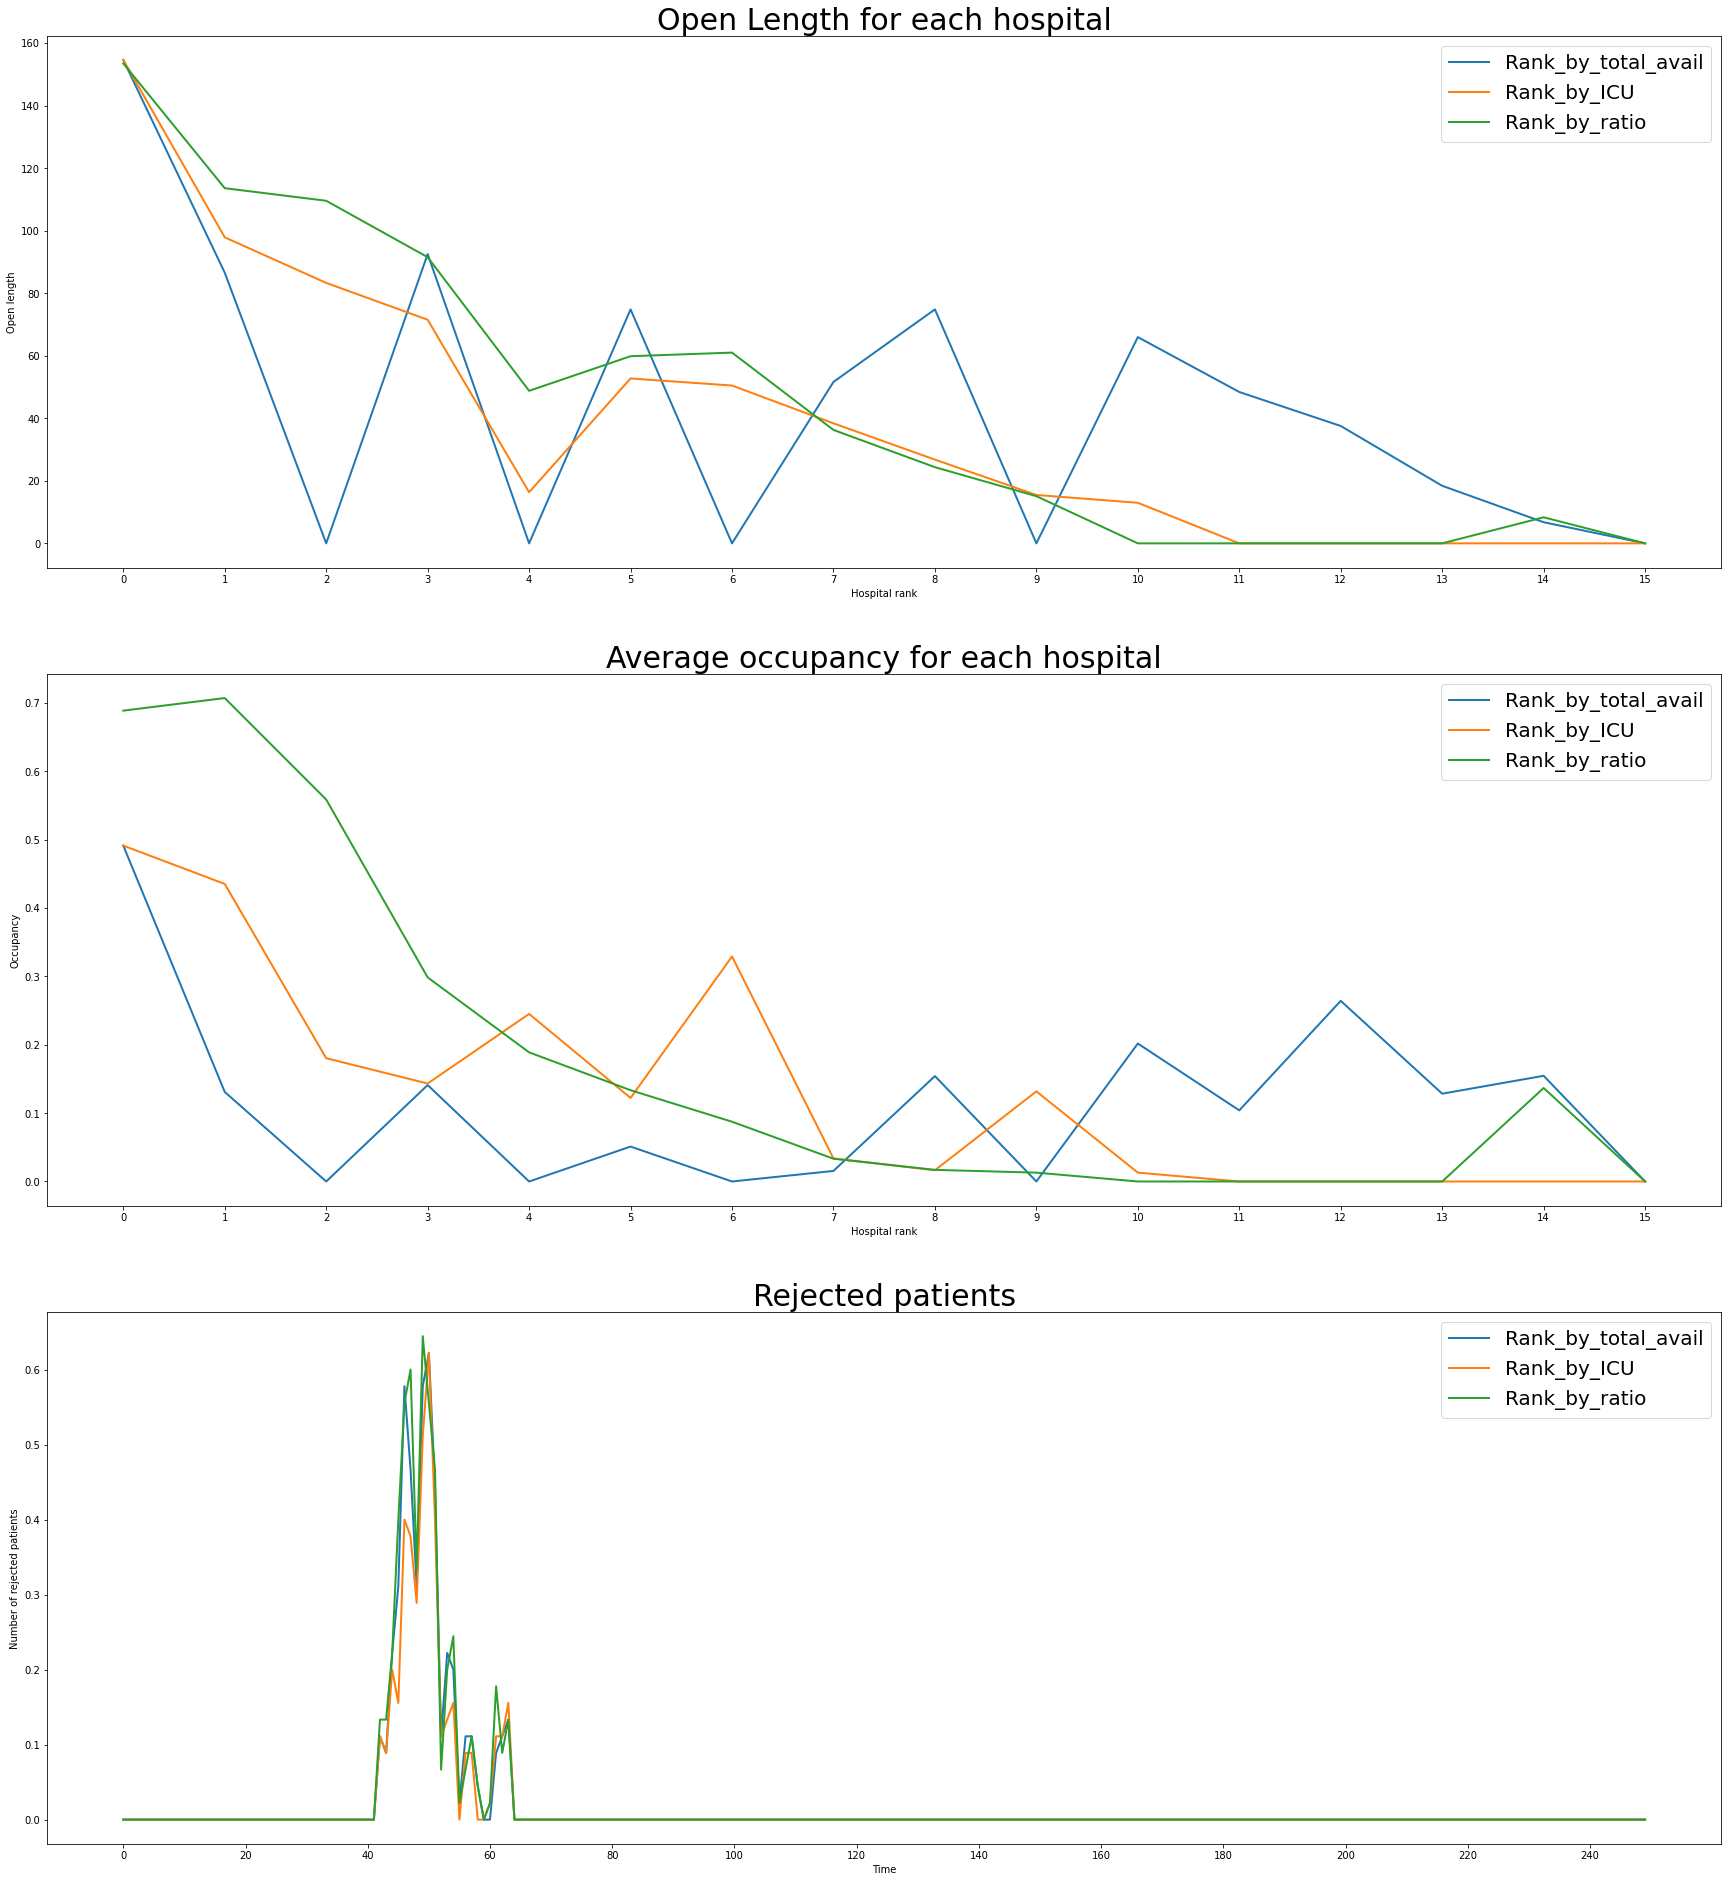

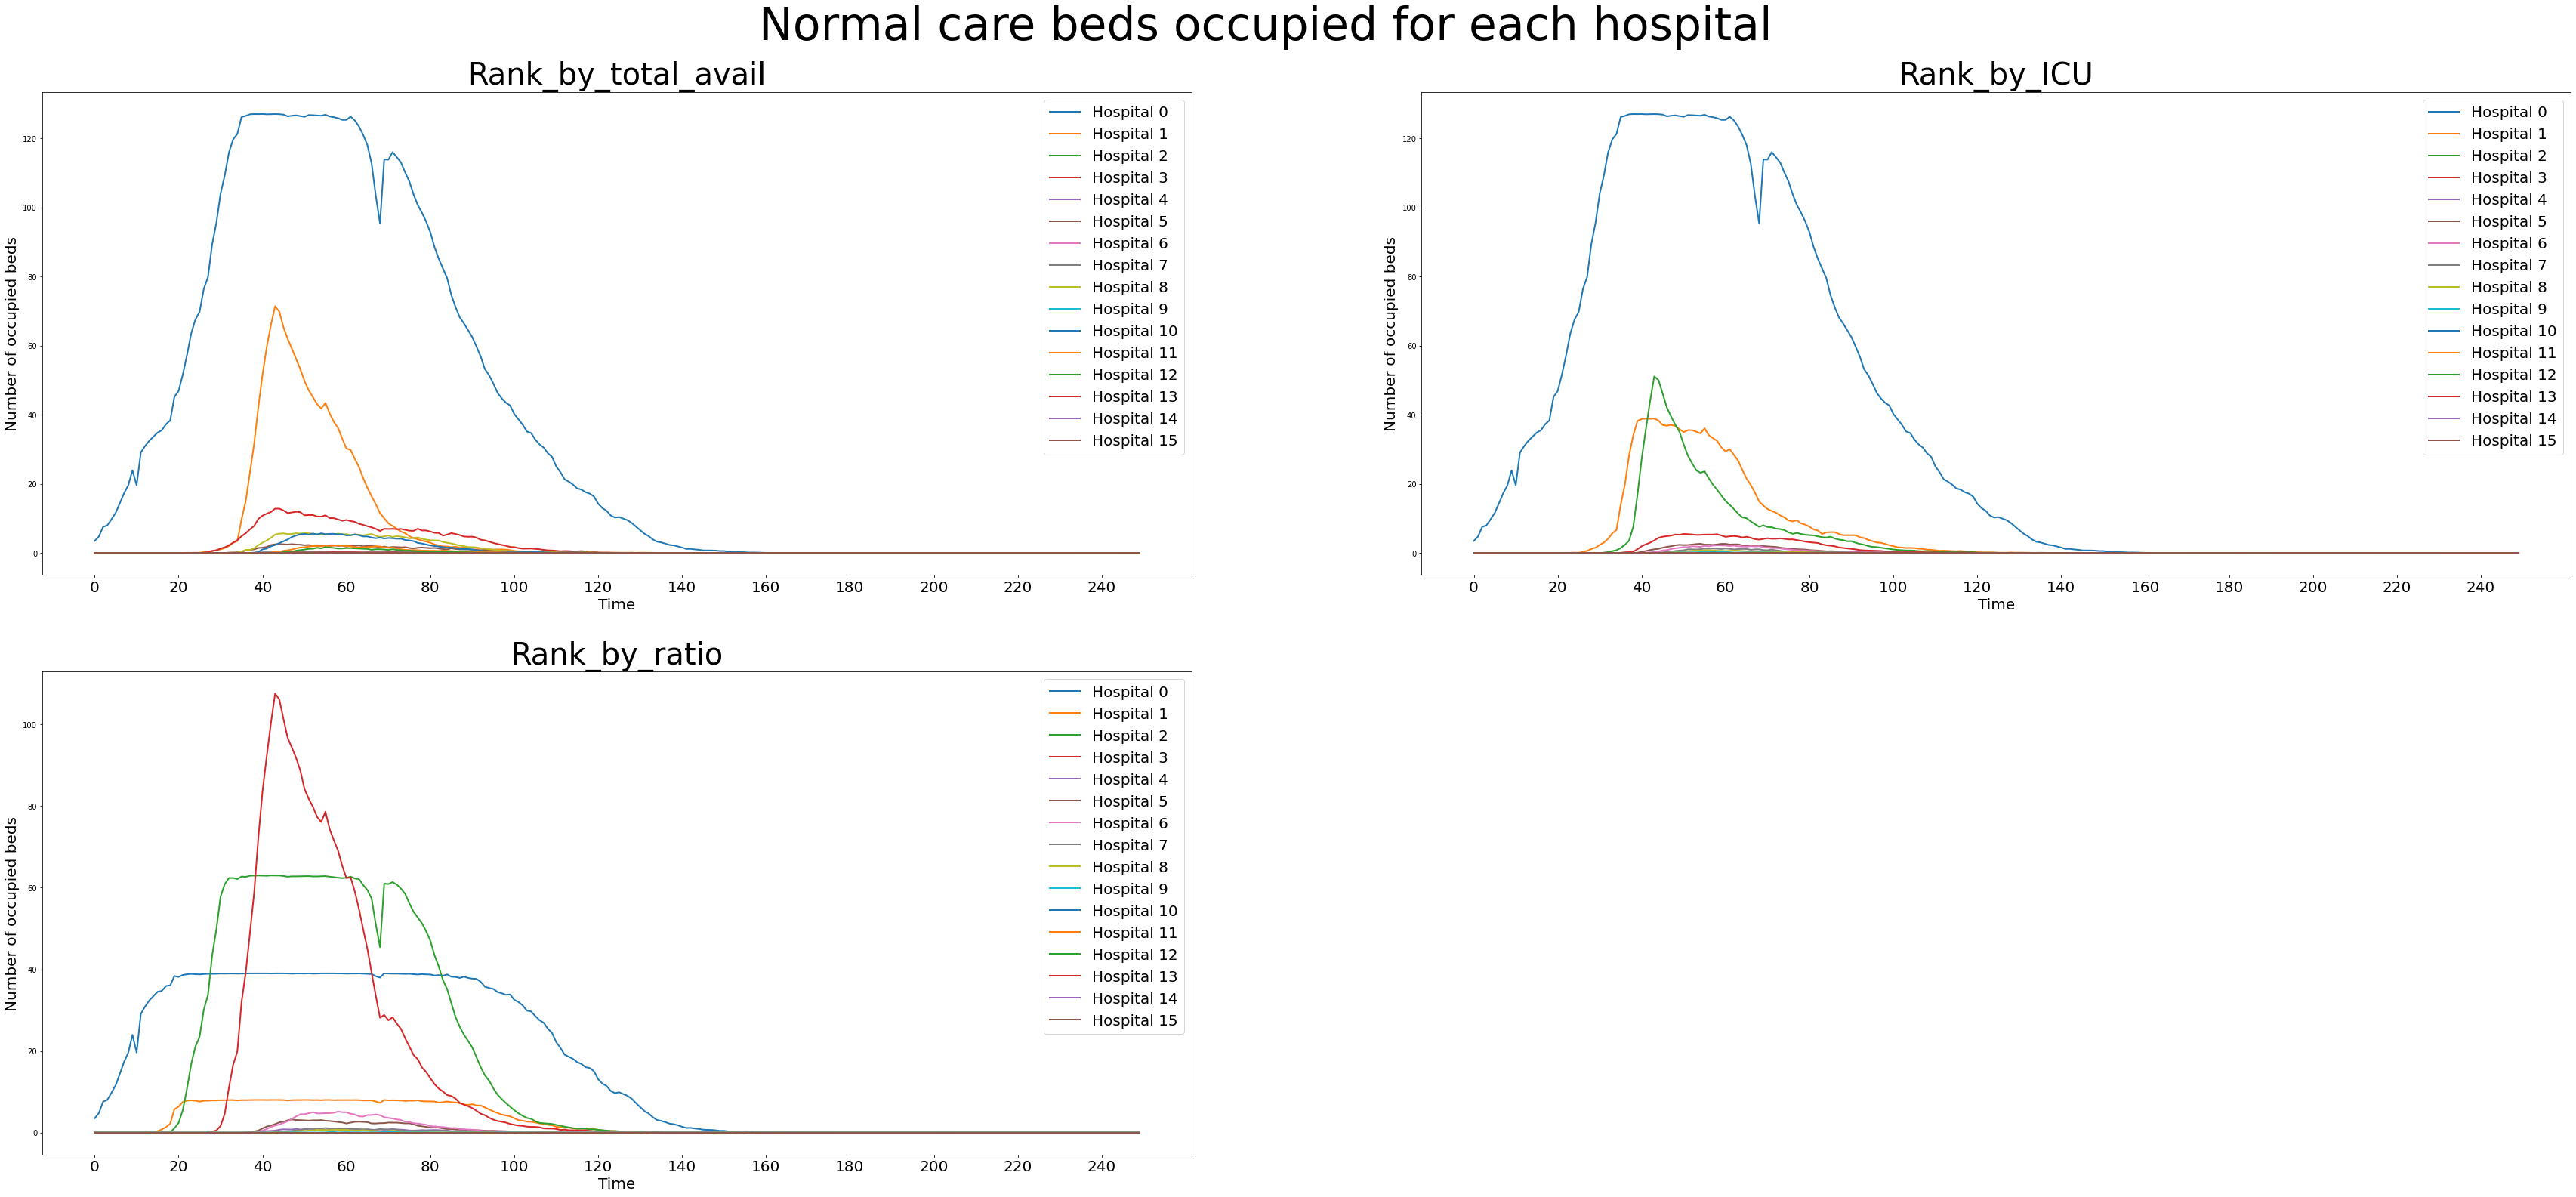

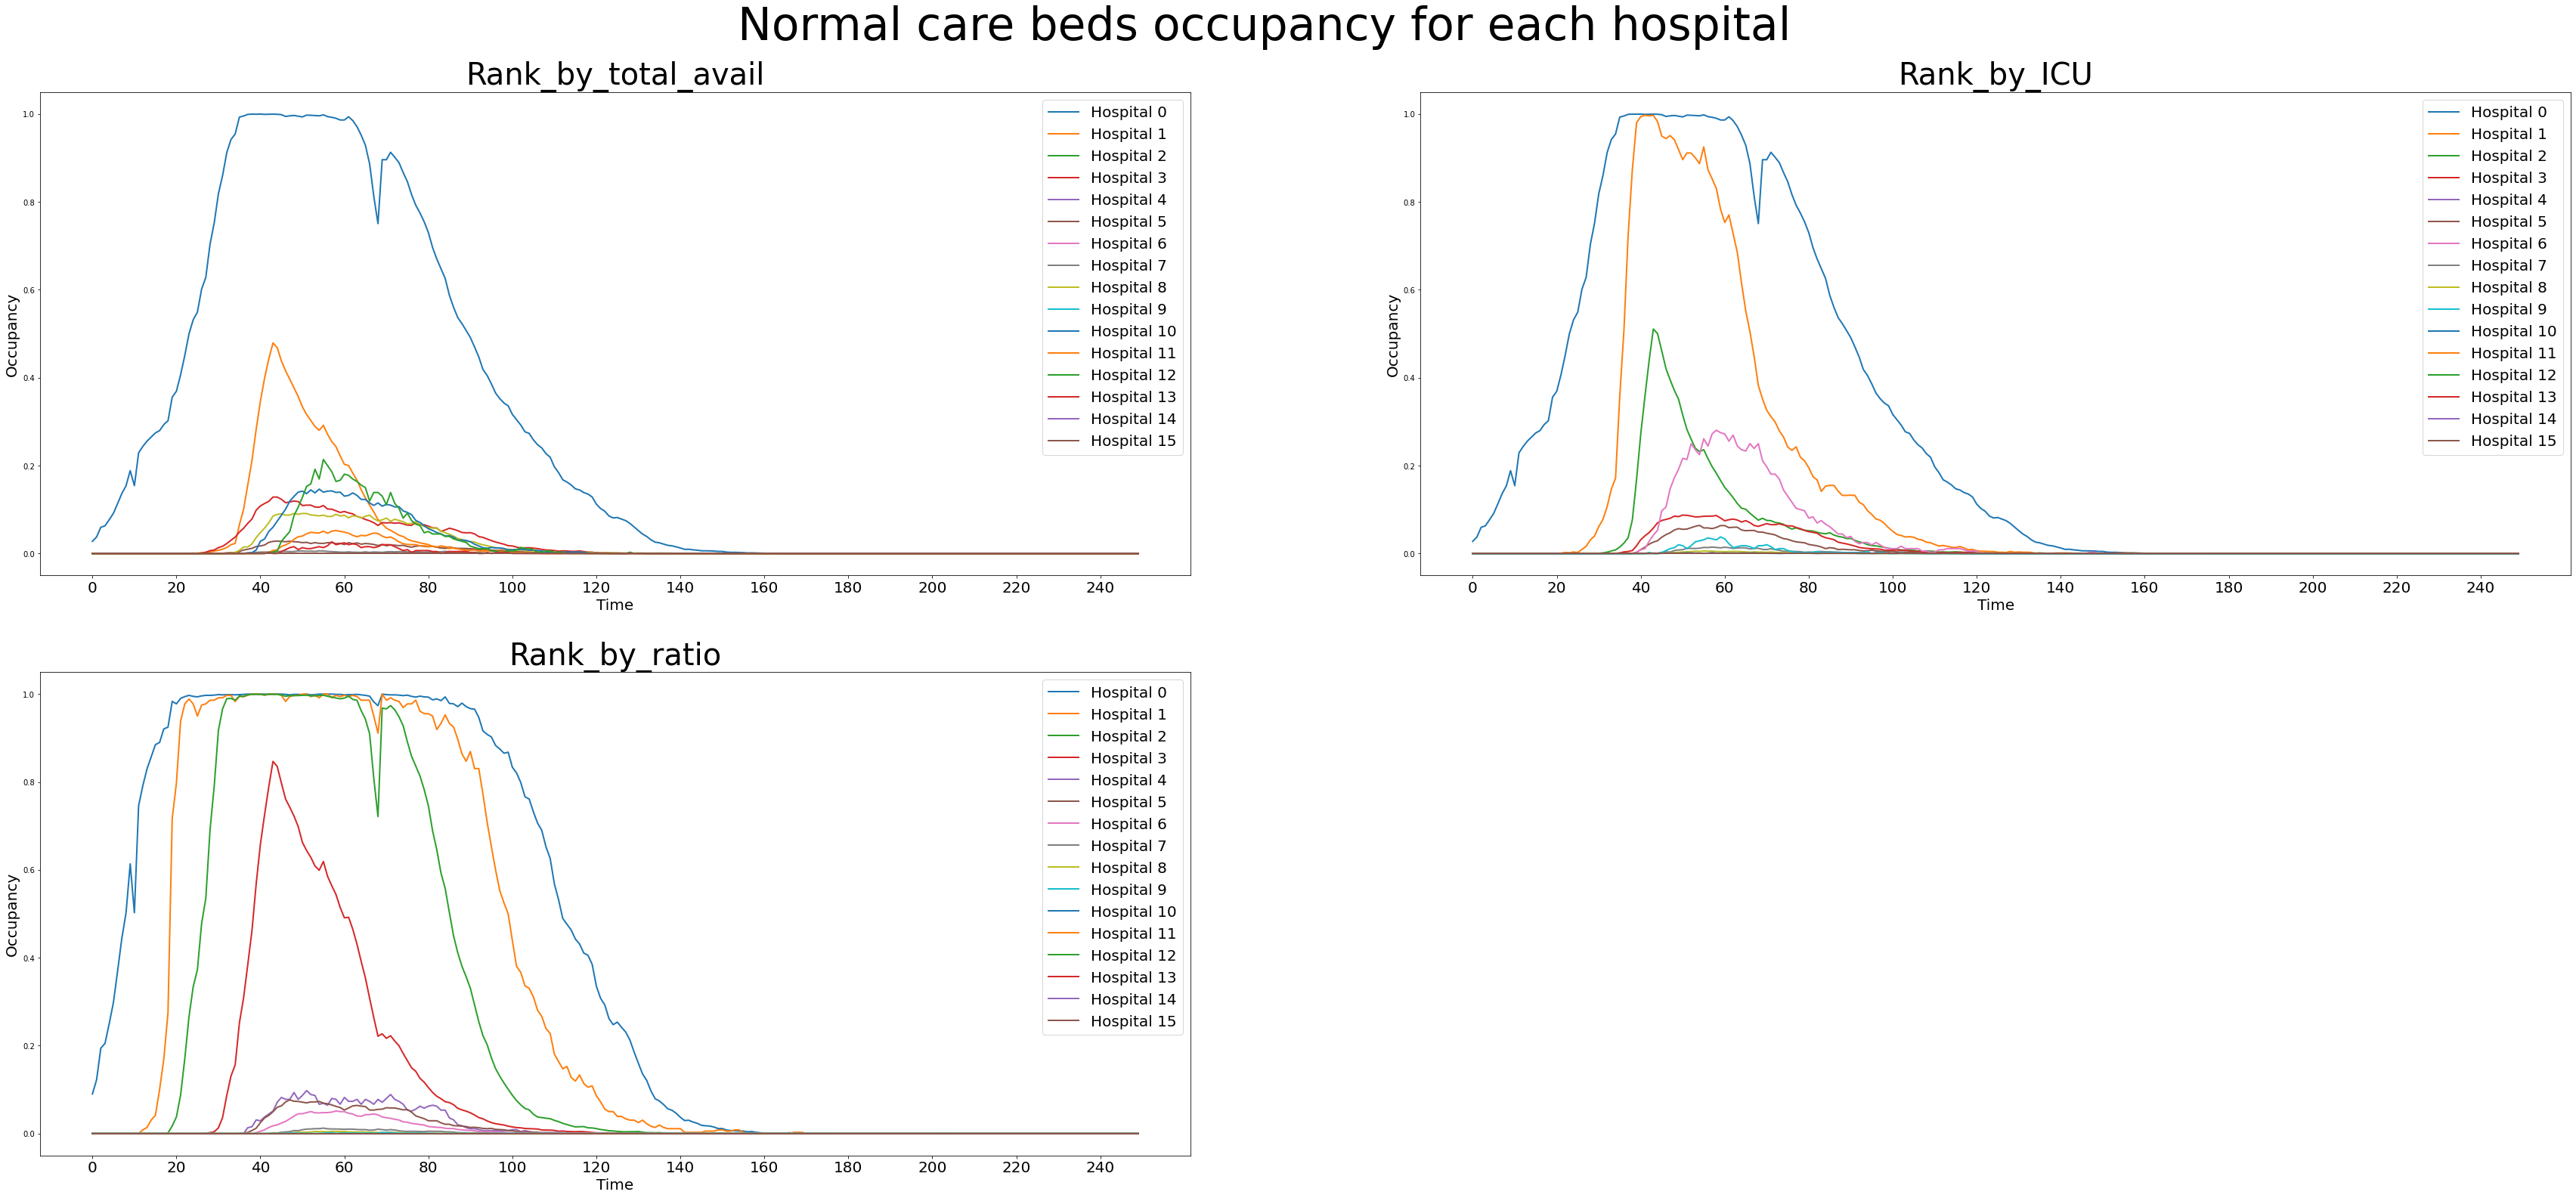

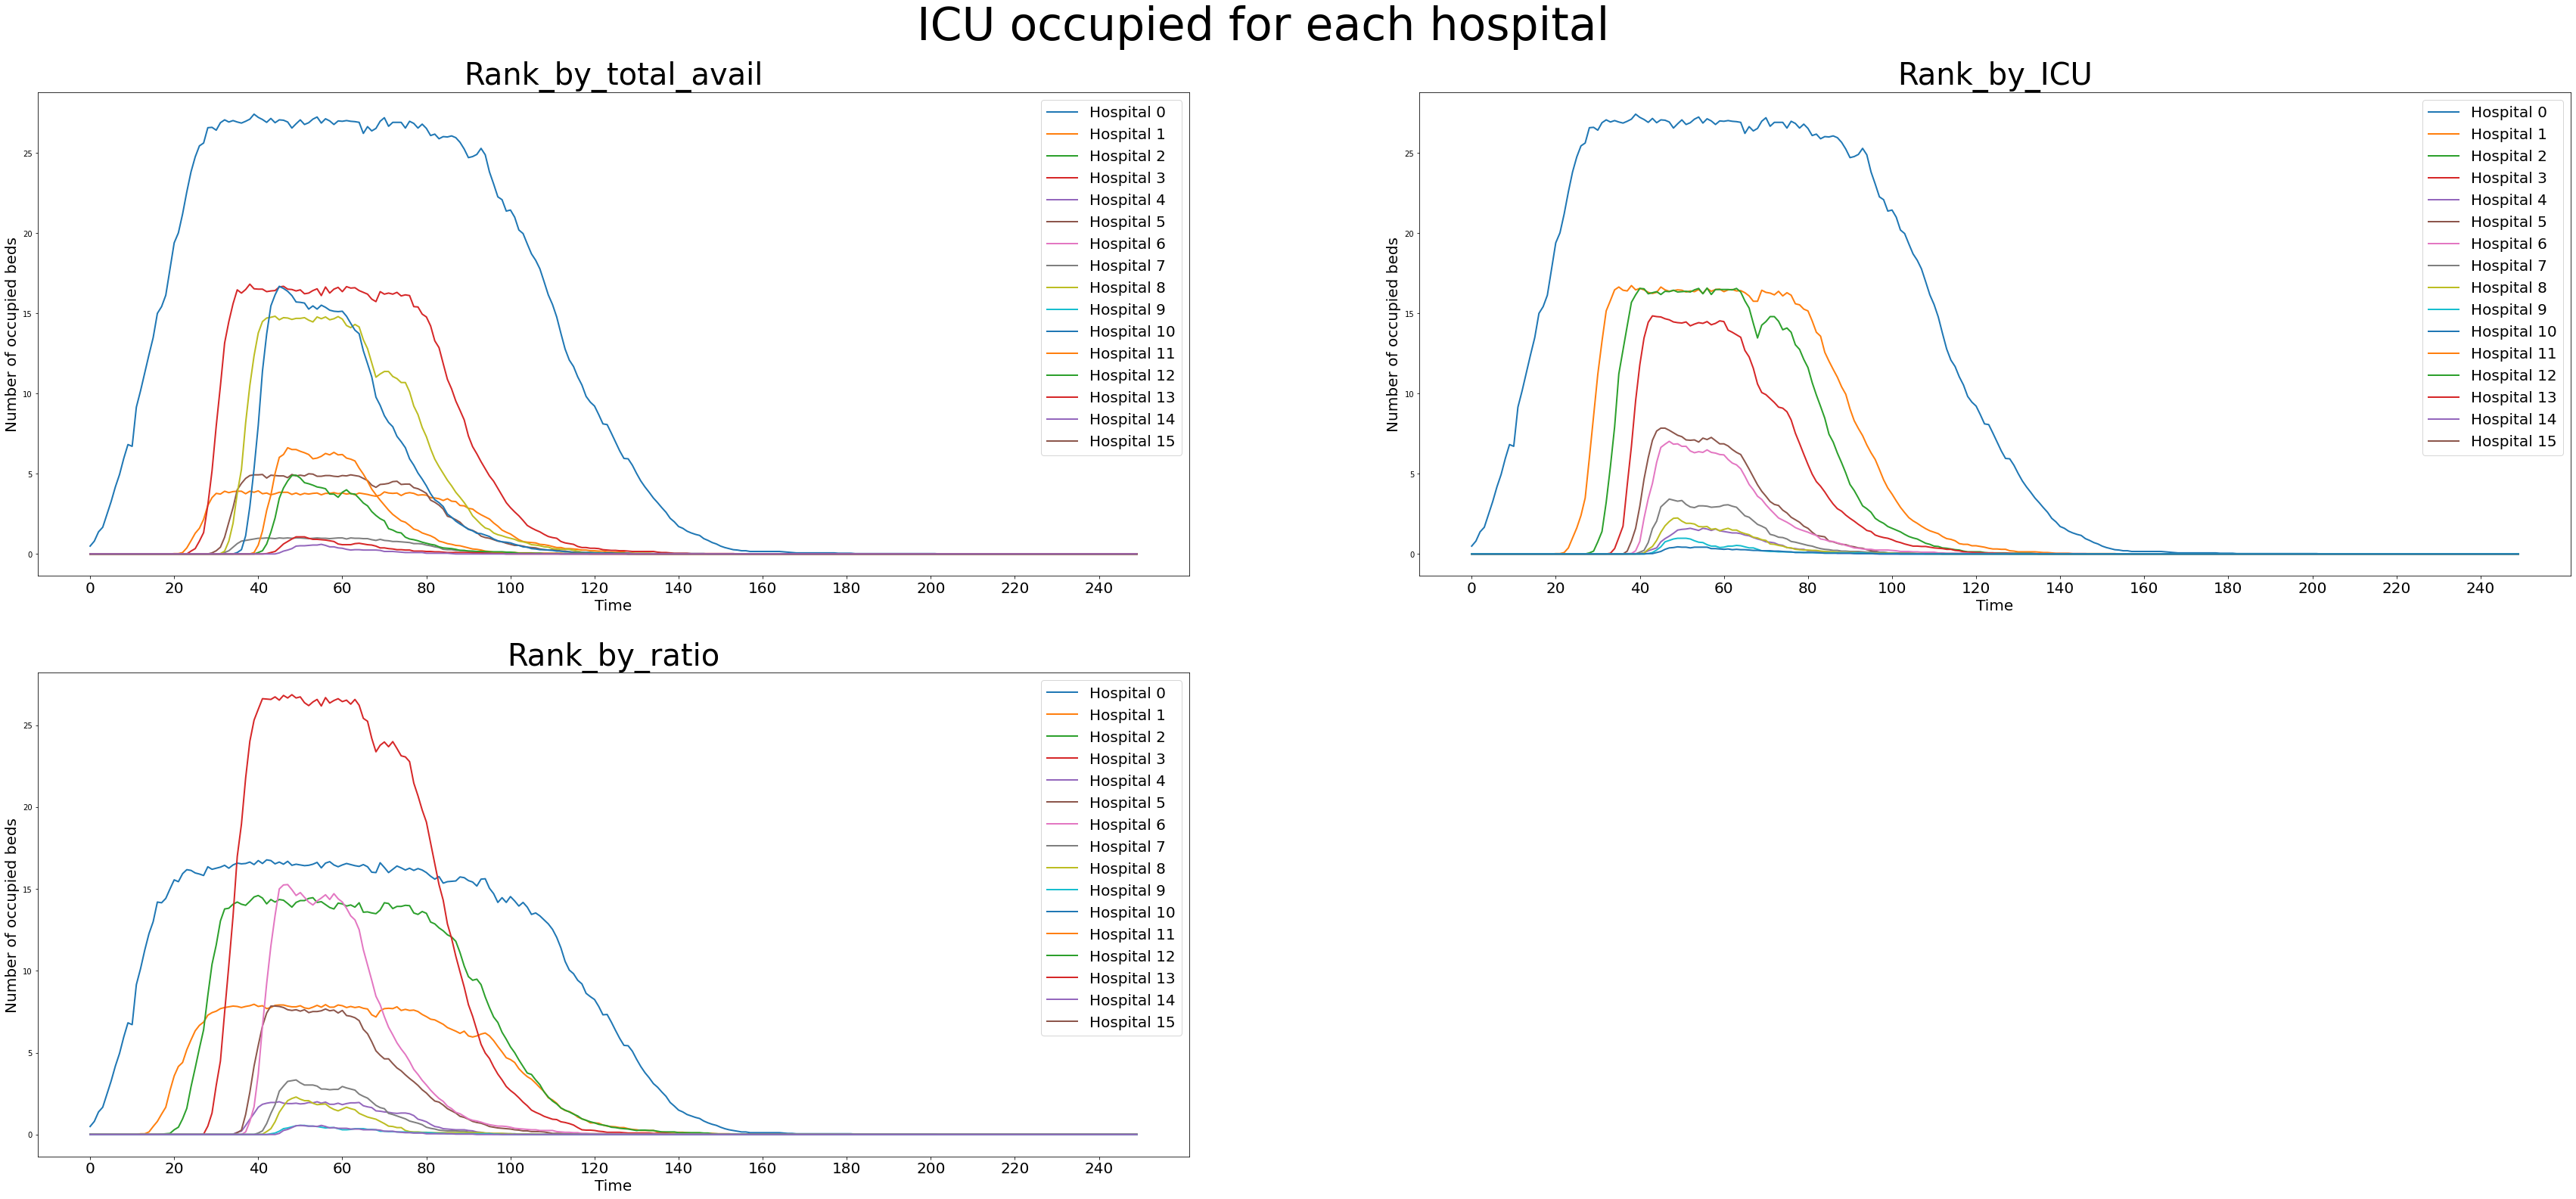

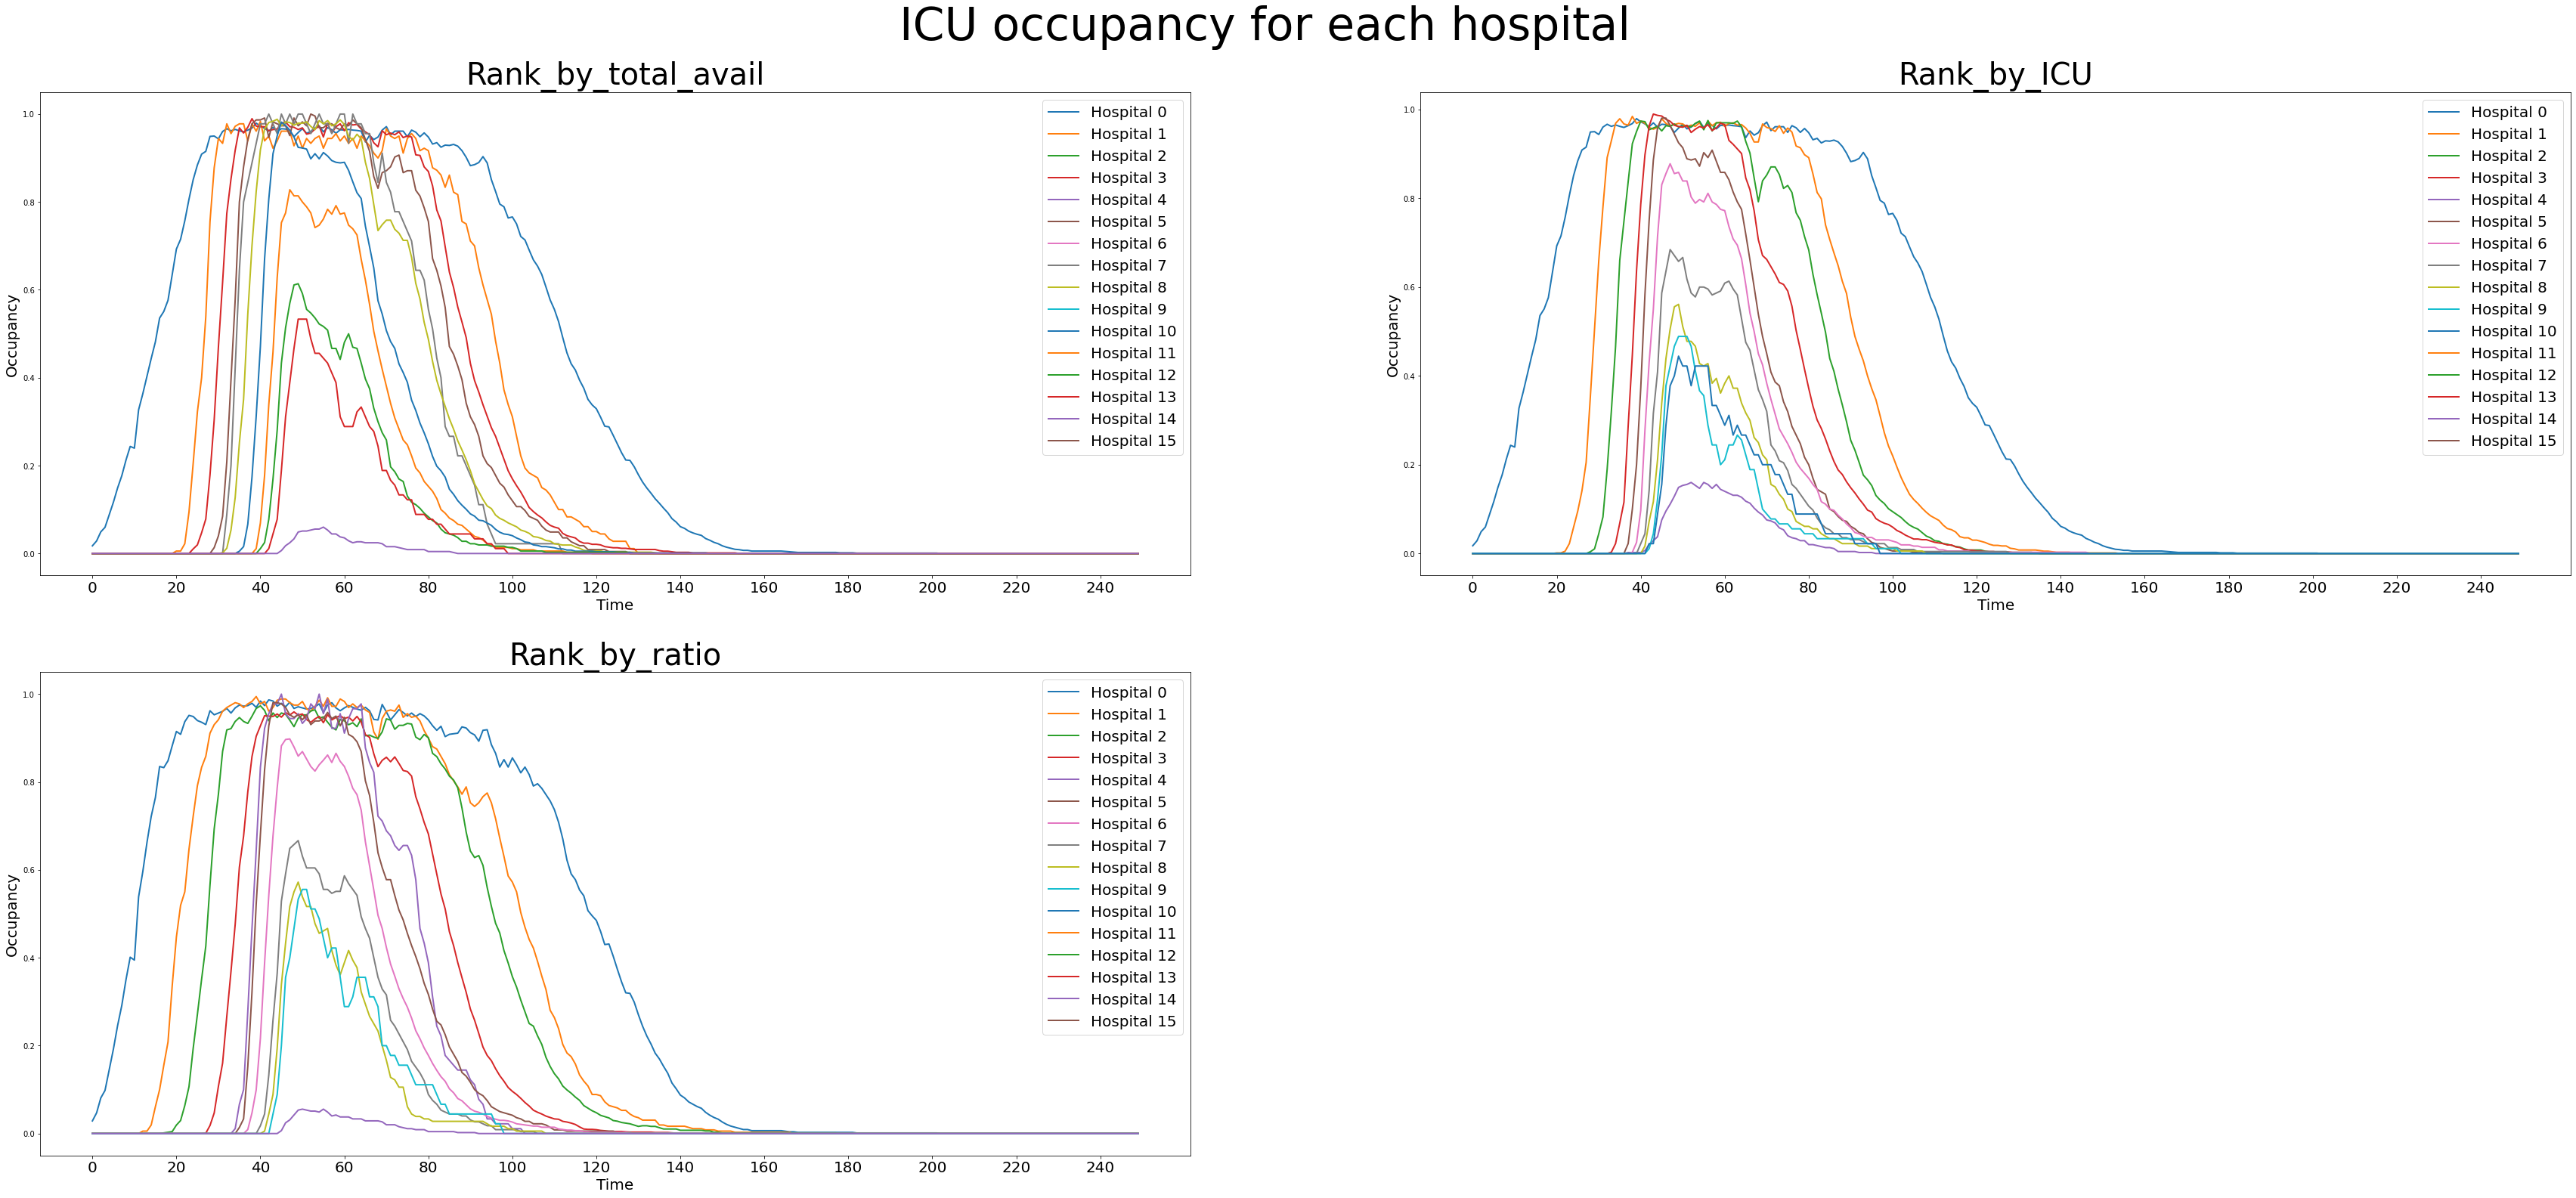

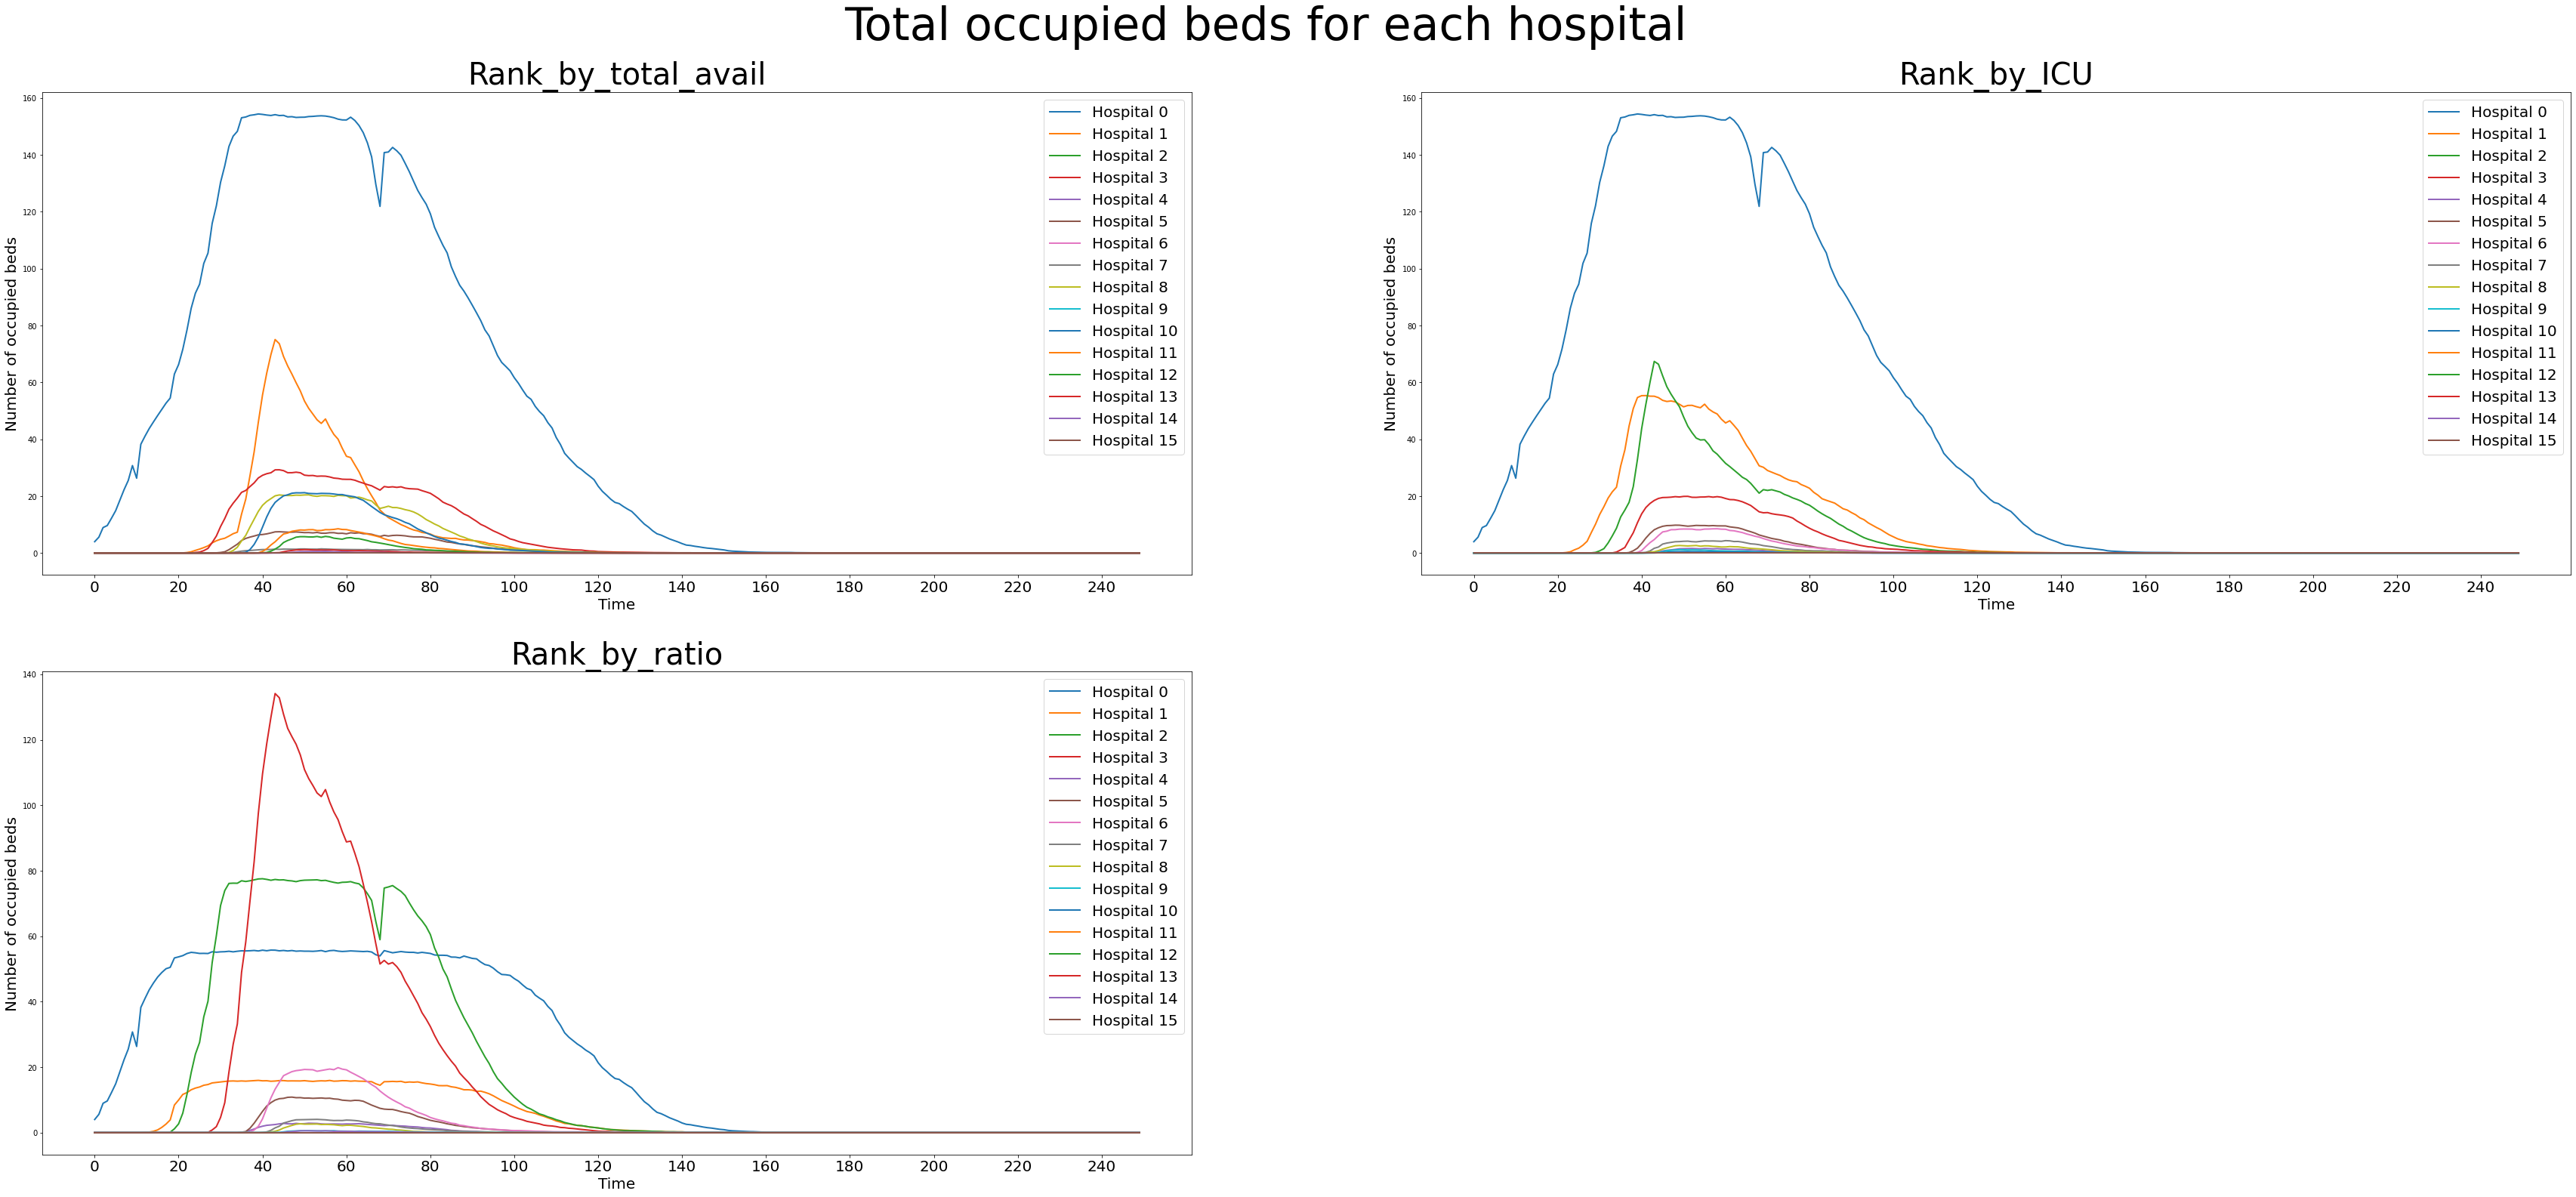

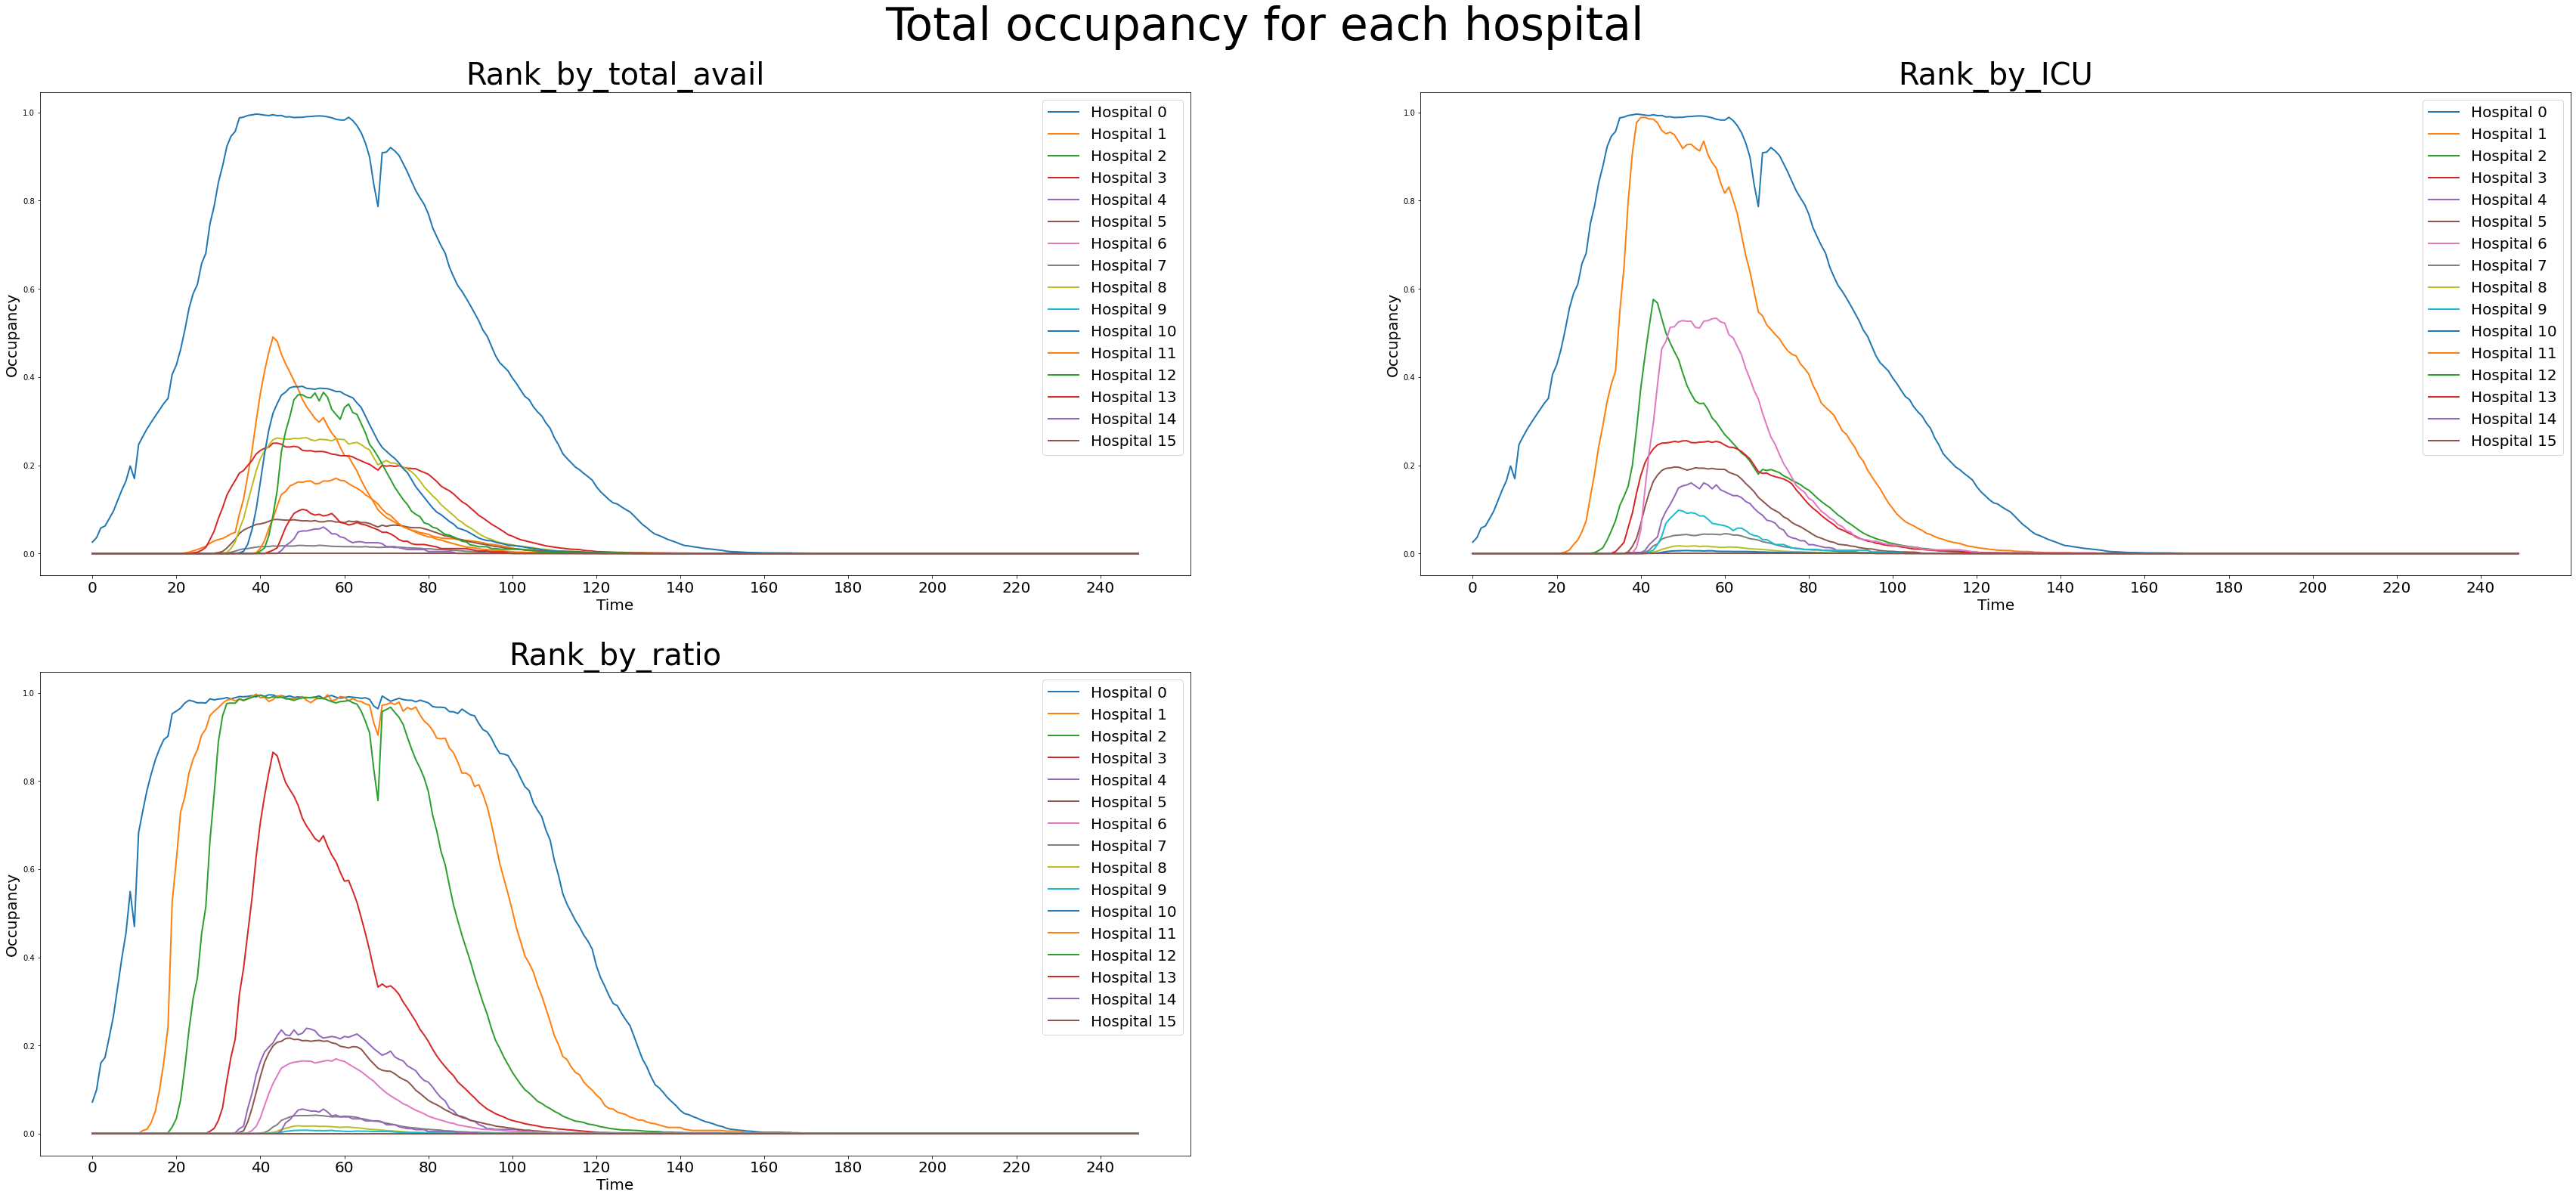

In [10]:
NUM_REPLICATE = 45
Rank = ['Rank_by_total_avail','Rank_by_ICU','Rank_by_ratio']

# initialize global lists across Rank
candid_count_glob_glob, not_open_NC_glob_glob, not_open_ICU_glob_glob= [],[],[]
count_glob_glob, reject_glob_glob, reject_daily_glob_glob = [],[],[]
NC_bed_total_glob_glob, NC_occ_total_glob_glob, ICU_bed_total_glob_glob, ICU_occ_total_glob_glob = [],[],[],[]
Daily_open_total_glob_glob, Open_total_glob_glob, avg_occ_glob_glob =[],[],[]
total_bed_glob_glob,total_occ_glob_glob =[],[]    

for i in range(len(Rank)):
    # initialize replication lists
    candid_count_glob, not_open_NC_glob, not_open_ICU_glob= [],[],[]
    reject_glob, reject_daily_glob,count_glob = [],[],[]
    NC_bed_total_glob, NC_occ_total_glob, ICU_bed_total_glob, ICU_occ_total_glob = [],[],[],[]
    Daily_open_total_glob, Open_total_glob =[],[]
    total_bed_glob =[]
    for j in range(NUM_REPLICATE):
        start = time.process_time()
        random.seed(j)
        globvars = Globvars(Rank[i],'admis_mean', j)
        model = Simulation(globvars)
        model.run()
    sum_result()


plot_result_final()

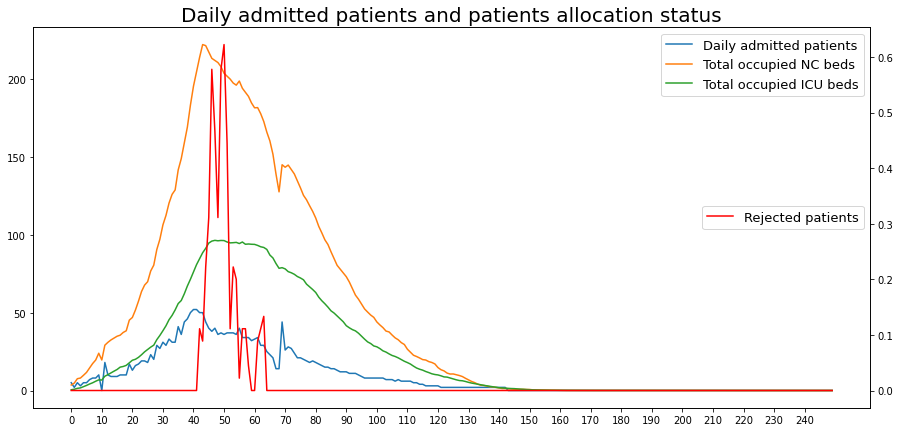

In [11]:
# Plot daily admitted patients and patient allocation status
patient_admit = pd.read_csv('data/patient_admit.csv')
daily_admit =[]
for key, value in patient_admit.iterrows():
    today_new_patient=[]
    daily_admit.append(value['admis_upper'])

fig, ax1 = plt.subplots(figsize = (15,7))
ax2 = ax1.twinx()
for i in range(1):
    ax2.plot(reject_daily_glob_glob[i], color = 'r', label = 'Rejected patients')

ax1.plot(daily_admit, label = 'Daily admitted patients')
ax1.plot(np.divide((np.asarray(sum(NC_bed_total_glob_glob)).sum(axis=0)),3), label = "Total occupied NC beds")
ax1.plot(np.divide((np.asarray(sum(ICU_bed_total_glob_glob)).sum(axis=0)),3), label = "Total occupied ICU beds")
ax1.legend(loc="upper right", fontsize=13)
ax2.legend(loc="center right", fontsize=13)
plt.xticks(np.arange(0, 250, step=10))
plt.title("Daily admitted patients and patients allocation status", fontsize = 20)
plt.show()  